In [1]:

import torch
import logging
import statistics
import src.clip as clip
from torchinfo import summary
import torchvision.transforms as T
from accelerate import Accelerator
from yacs.config import CfgNode as CN
from main import get_config, init_accelerator, set_seed, FFPP
from src.models import Detector
logging.basicConfig(level="INFO")


class Obj:
    pass


c = FFPP.get_default_config()
c.augmentation = "dev-mode+force-rgb"
c.random_speed = False
c.compressions = ["c23"]
c.types = ["REAL", "FS", "F2F", "DF", "NT"]


mc = Detector.get_default_config()
mc.out_dim = [2]
mc.adapter = CN()
mc.adapter.frozen = 0
mc.adapter.struct = CN()
mc.adapter.struct.type = "768-x-768-nln"
mc.adapter.struct.x = 256
mc.adapter.type = "normal"

accelerator = Accelerator(mixed_precision='no')
model = Detector(mc, 20, accelerator).to(accelerator.device).eval()
encoder = model.encoder
model.eval()
model.to("cuda")

transform = T.Compose([
    T.Resize(encoder.input_resolution, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(encoder.input_resolution),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711)),
])

x = FFPP(c.clone(), 20, 5, transform, accelerator, split="train")
_x = FFPP(c.clone(), 20, 5, lambda x: x, accelerator, split="train")
c

/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:Adapter operates without pretrained weights!!!
100%|██████████| 5/5 [00:00<00:00, 2947.92it/s]


CfgNode({'category': 'train', 'root_dir': './datasets/ffpp/', 'detection_level': 'video', 'types': ['REAL', 'FS', 'F2F', 'DF', 'NT'], 'compressions': ['c23'], 'name': 'FFPP', 'scale': 1.0, 'pack': 0, 'pair': 0, 'contrast': 0, 'augmentation': 'dev-mode+force-rgb', 'random_speed': False})

In [4]:
import random
idx = random.randint(0, len(x))
s = random.random() * 10000
random.seed(s)
data0 = x[idx]
data1 = x[idx]
random.seed(s)
_data0 = _x[idx]
_data1 = _x[idx]

In [5]:
data = [{
    "d1": data0[0]["c23"],
    "d2": data1[0]["c23"]
}]

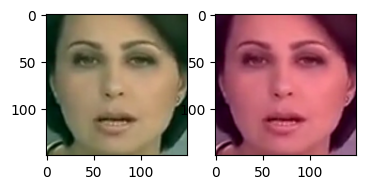

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(_data0[0]["c23"][0].numpy().transpose((1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(_data1[0]["c23"][0].numpy().transpose((1, 2, 0)))

In [ ]:
# features = {}
# nfeatures = {}
# with torch.no_grad():
#     for k, v in data[0].items():
#         # get key and value from each CLIP ViT layer
#         kvs = encoder(v[0].unsqueeze(0).to("cuda"))
#         # discard original CLS token and restore temporal dimension
#         kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]

#         _kvs = [{k: v.unsqueeze(0) for k, v in kv.items()} for kv in kvs]
#         _kvs = adapter([kvs[i] for i in range(0, 12, 2)])

#         kvs = [{k: v.squeeze(0).view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in kvs]
#         features[k] = kvs
#         _kvs = [{k: v.squeeze(0).view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in _kvs]
#         nfeatures[k] = _kvs


# torch.cuda.empty_cache()

In [7]:
features = {}

with torch.no_grad():
    for k, v in data[0].items():
        # get key and value from each CLIP ViT layer
        kvs = encoder(v.to("cuda"))
        # discard original CLS token and restore temporal dimension
        kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]

        kvs = [{k: v[0].view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in kvs]

        features[k] = kvs


torch.cuda.empty_cache()

In [8]:
methods = []

In [9]:
# l = {
#     "k": [],
#     "v": []
# }
# for layer in range(12):
#     for subject in ["k", "v"]:
#         l[subject].append(
#             torch.nn.functional.mse_loss(
#                 features["d1"][layer][subject],
#                 features["d2"][layer][subject],
#                 reduction="none"
#             ).mean(dim=-1).view(14, 14).numpy()
#         )
# methods.append(l)

In [10]:
l = {
    "k": [],
    "v": []
}
for layer in range(12):
    for subject in ["k", "v"]:
        l[subject].append(
            torch.nn.functional.kl_div(
                torch.nn.functional.log_softmax(features["d1"][layer][subject], dim=-1),
                torch.nn.functional.log_softmax(features["d2"][layer][subject], dim=-1),
                log_target=True,
                reduction="none"
            ).mean(dim=-1).view(14, 14).numpy()
        )
methods.append(l)

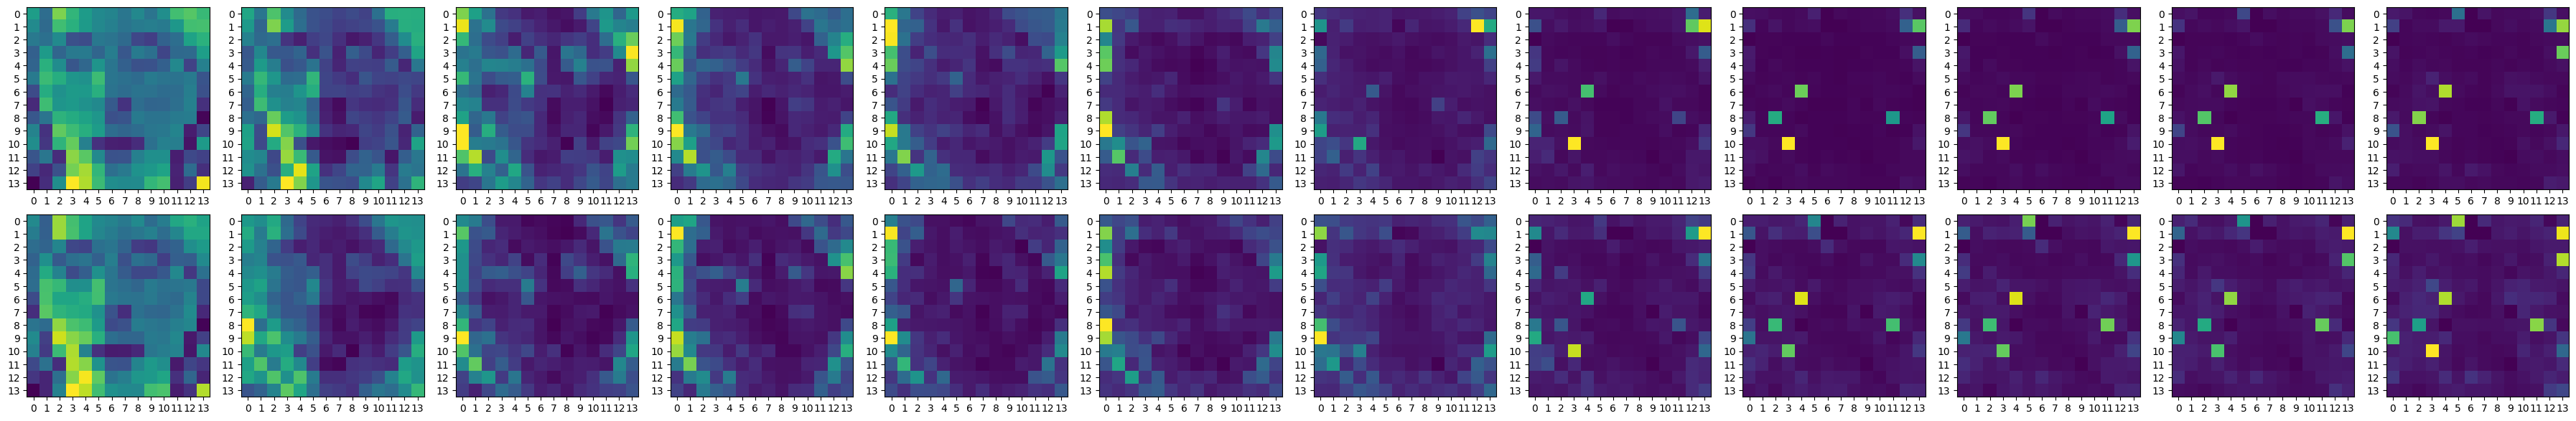

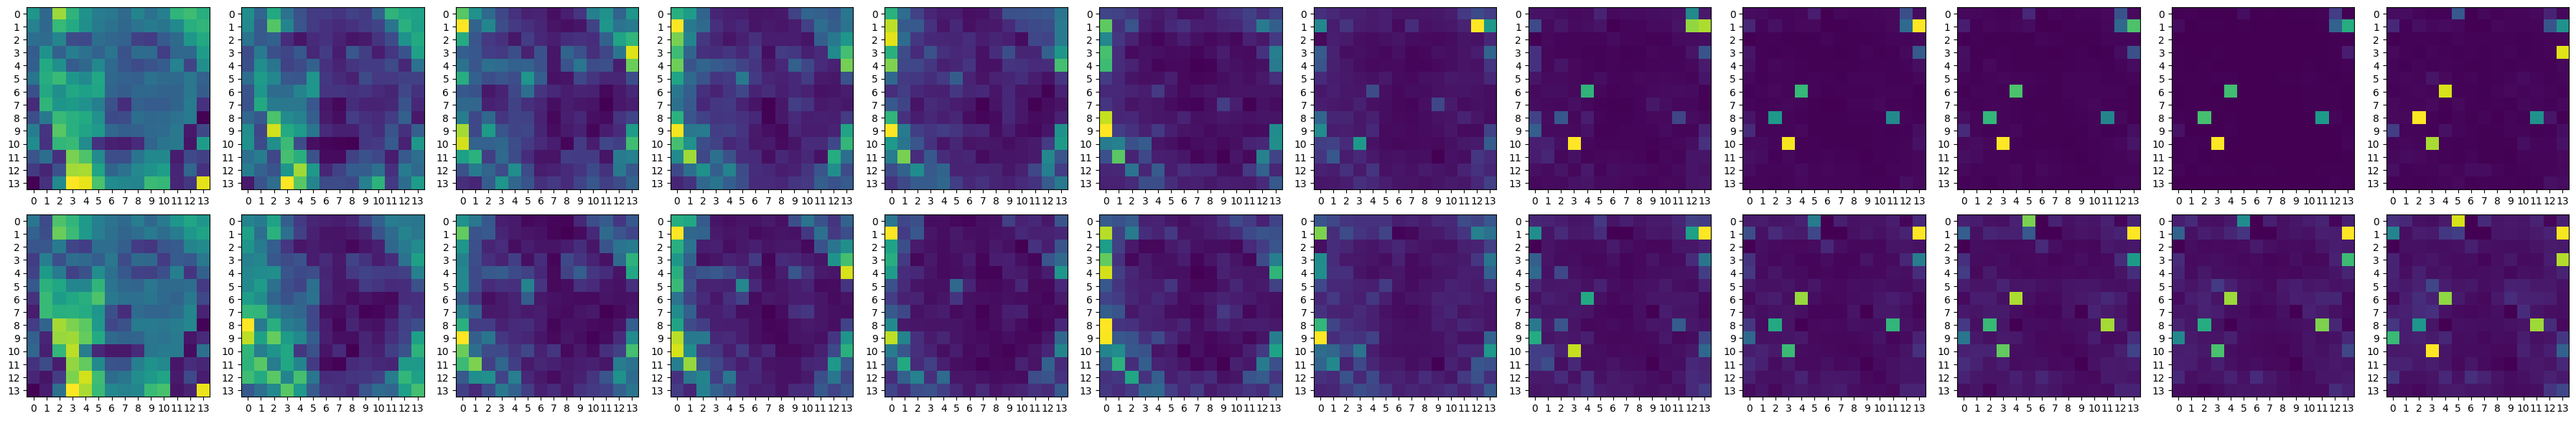

In [11]:
import numpy as np
import matplotlib.pyplot as plt
for l in methods:
    plt.figure(figsize=(36, 6))
    for j, s in enumerate(["k", "v"]):
        for i, v in enumerate(l[s]):
            plt.subplot(2, 12, j * 12 + i + 1)
            im = plt.imshow(v)

            # Show all ticks and label them with the respective list entries
            plt.gca().set_xticks(np.arange(14))
            plt.gca().set_yticks(np.arange(14))

            # Rotate the tick labels and set their alignment.
            # plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
            #          rotation_mode="anchor")

    plt.tight_layout()
    plt.show()

INFO:root:dev-mode+force-hue
 97%|█████████▋| 970/1000 [08:22<00:15,  1.89it/s]ERROR:root:Error occur: 
ERROR:root:Error occur: 
100%|██████████| 1000/1000 [08:37<00:00,  1.93it/s]


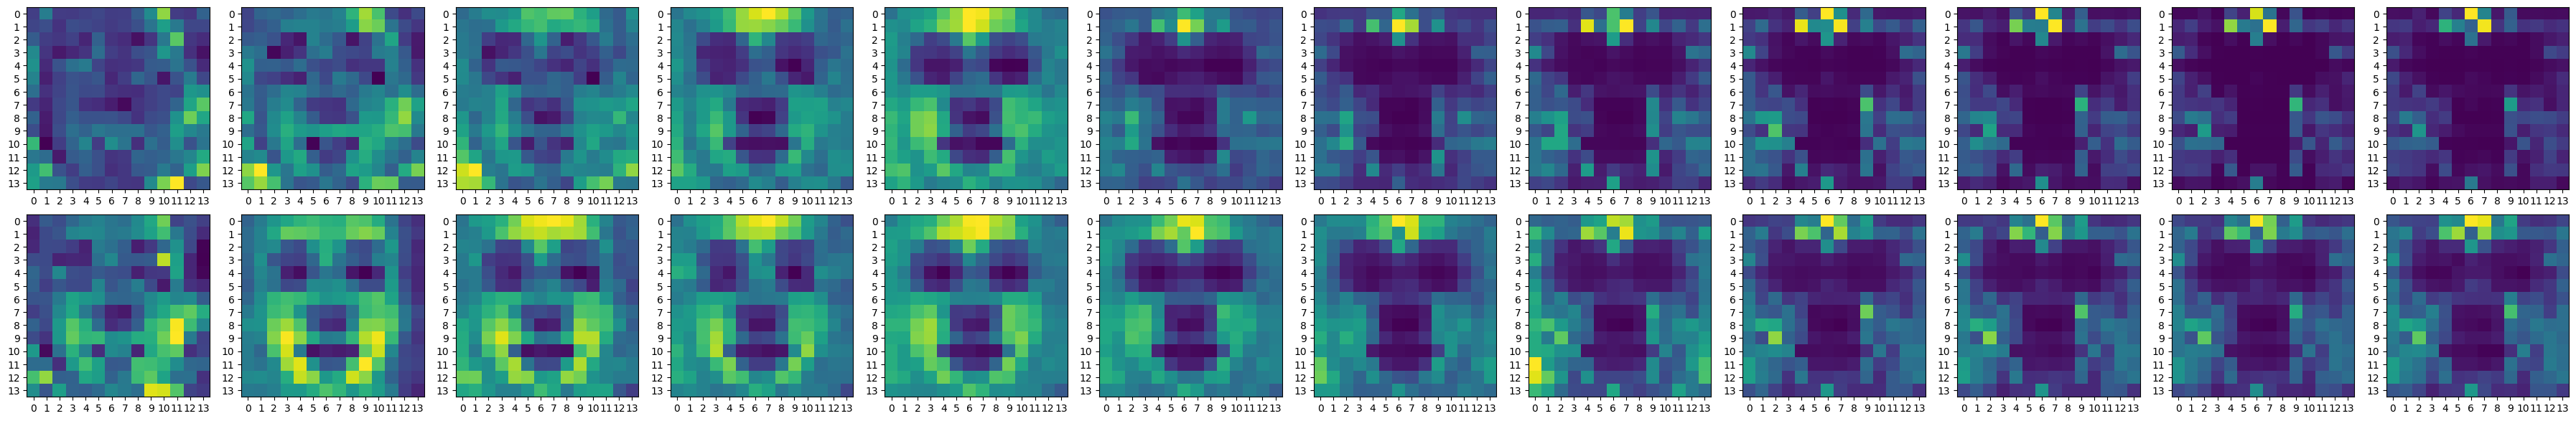

INFO:root:Diff map saved for setting:dev-mode+force-hue
INFO:root:dev-mode+force-bright
100%|██████████| 1000/1000 [08:25<00:00,  1.98it/s]


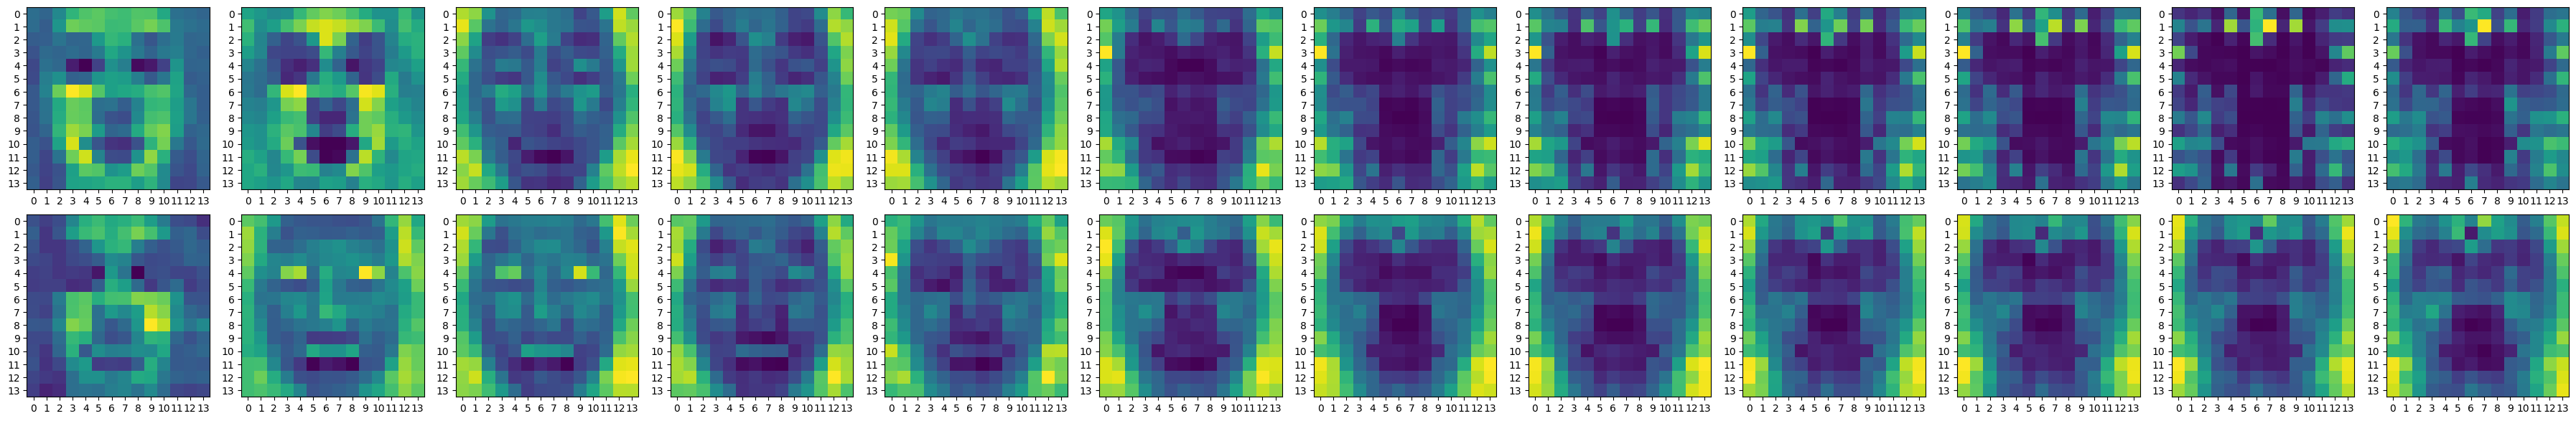

INFO:root:Diff map saved for setting:dev-mode+force-bright
INFO:root:dev-mode+force-rgb
100%|██████████| 1000/1000 [08:24<00:00,  1.98it/s]


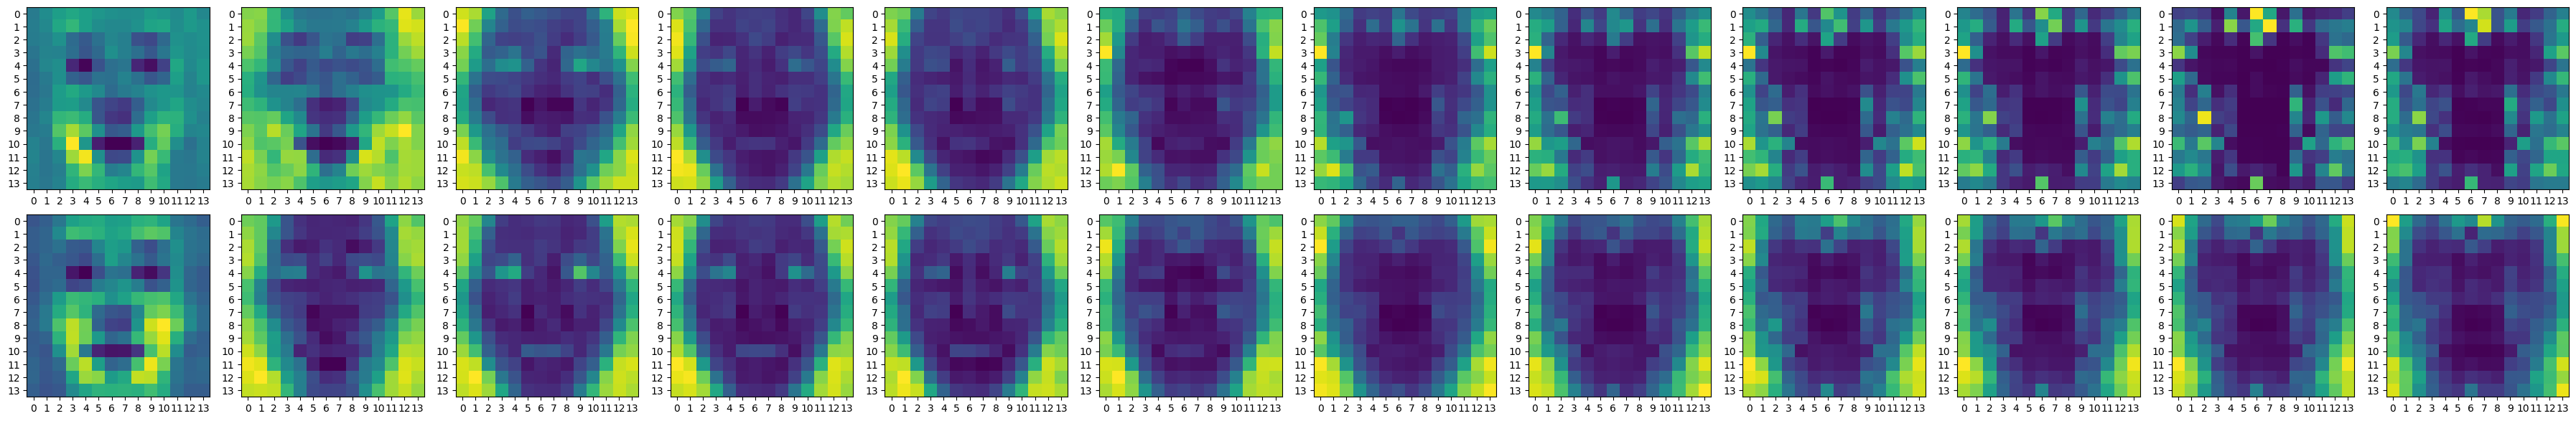

INFO:root:Diff map saved for setting:dev-mode+force-rgb


In [2]:
import pickle
import random
from tqdm import tqdm

num_samples = 1000
for setting in ["dev-mode+force-hue", "dev-mode+force-bright", "dev-mode+force-rgb"]:
    logging.info(setting)
    c.augmentation = setting
    x = FFPP(c.clone(), 20, 5, transform, accelerator, split="train")
    image_features = []
    for _ in tqdm(range(num_samples)):
        idx = random.randint(0, len(x))
        data0 = x[idx]
        data1 = x[idx]

        data = [{
            "d1": data0[0]["c23"],
            "d2": data1[0]["c23"]
        }]

        features = {}

        with torch.no_grad():
            for k, v in data[0].items():
                # get key and value from each CLIP ViT layer
                kvs = encoder(v.to("cuda"))
                # discard original CLS token and restore temporal dimension
                kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
                kvs = [{k: v[0].view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in kvs]
                features[k] = kvs
            image_features.append(features)

        torch.cuda.empty_cache()

    methods = []

    ls = []
    for features in image_features:
        l = {
            "k": [],
            "v": []
        }
        for layer in range(12):
            for subject in ["k", "v"]:
                l[subject].append(
                    # torch.nn.functional.mse_loss(
                    #     features["d1"][layer][subject],
                    #     features["d2"][layer][subject],
                    #     reduction="none"
                    # ).mean(dim=-1).view(14, 14).numpy()
                    torch.nn.functional.kl_div(
                        torch.nn.functional.log_softmax(features["d1"][layer][subject], dim=-1),
                        torch.nn.functional.log_softmax(features["d2"][layer][subject], dim=-1),
                        log_target=True,
                        reduction="none"
                    ).mean(dim=-1).view(14, 14).numpy()
                )
        ls.append(l)

    l = ls[0]
    for _l in range(1, num_samples):
        for subject in ["k", "v"]:
            for layer in range(12):
                l[subject][layer] += ls[_l][subject][layer]

    for subject in ["k", "v"]:
        for layer in range(0, 12):
            l[subject][layer] /= num_samples

    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(36, 6))
    for j, s in enumerate(["k", "v"]):
        for i, v in enumerate(l[s]):
            plt.subplot(2, 12, j * 12 + i + 1)
            im = plt.imshow(v)

            plt.gca().set_xticks(np.arange(14))
            plt.gca().set_yticks(np.arange(14))

    plt.tight_layout()
    plt.show()

    logging.info(f"Diff map saved for setting:{setting}")
    with open(f"./misc/{c.augmentation}.pickle", "wb") as f:
        pickle.dump(l, f)

INFO:root:normal+frame
100%|██████████| 1000/1000 [09:12<00:00,  1.81it/s]


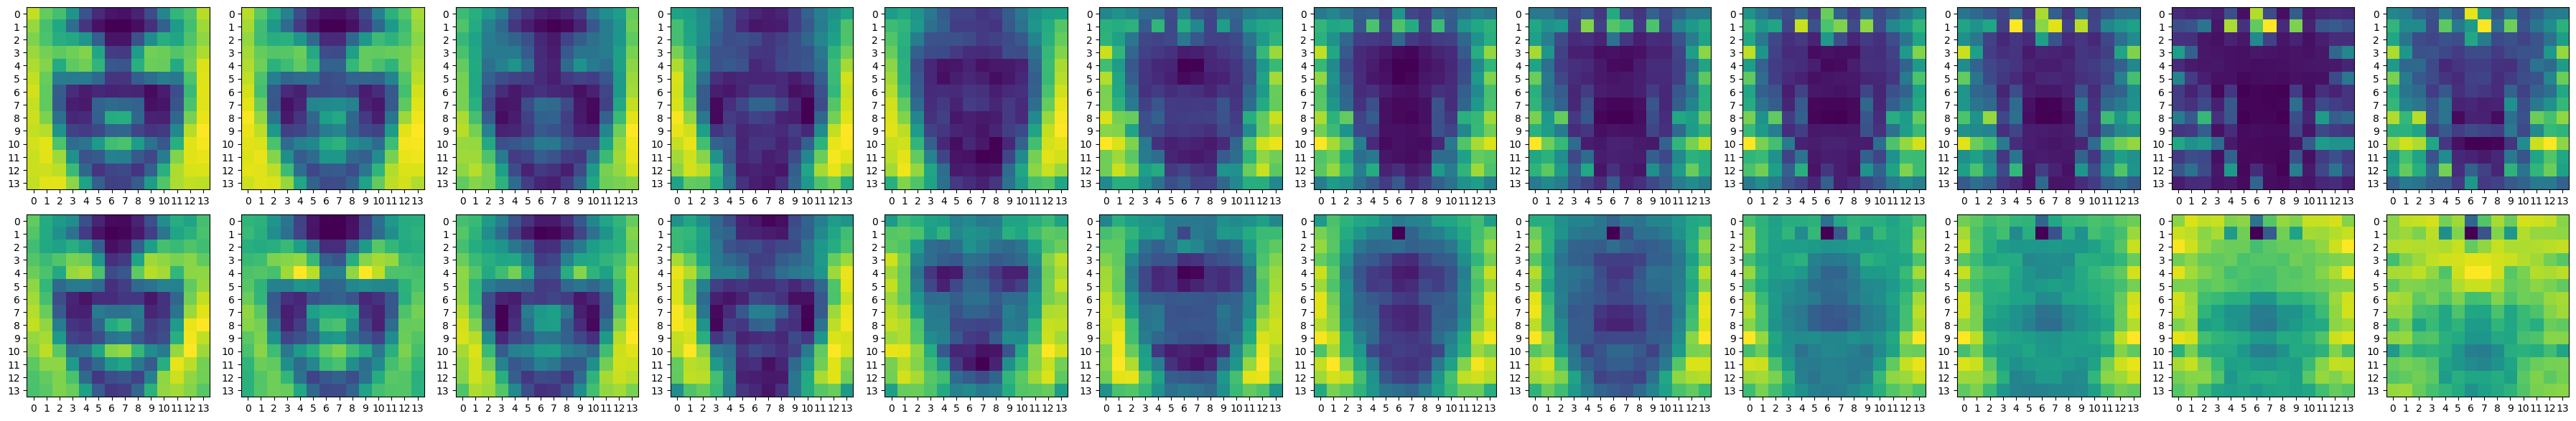

INFO:root:Diff map saved for setting:normal+frame


In [4]:
import pickle
import random
from tqdm import tqdm

num_samples = 1000
for setting in ["normal+frame"]:
    logging.info(setting)
    c.augmentation = setting
    x = FFPP(c.clone(), 20, 5, transform, accelerator, split="train")
    image_features = []
    for _ in tqdm(range(num_samples)):
        idx = random.randint(0, len(x))
        data0 = x[idx]
        idx = random.randint(0, len(x))
        data1 = x[idx]

        data = [{
            "d1": data0[0]["c23"],
            "d2": data1[0]["c23"]
        }]

        features = {}

        with torch.no_grad():
            for k, v in data[0].items():
                # get key and value from each CLIP ViT layer
                kvs = encoder(v.to("cuda"))
                # discard original CLS token and restore temporal dimension
                kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
                kvs = [{k: v[0].view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in kvs]
                features[k] = kvs
            image_features.append(features)

        torch.cuda.empty_cache()

    methods = []

    ls = []
    for features in image_features:
        l = {
            "k": [],
            "v": []
        }
        for layer in range(12):
            for subject in ["k", "v"]:
                l[subject].append(
                    # torch.nn.functional.mse_loss(
                    #     features["d1"][layer][subject],
                    #     features["d2"][layer][subject],
                    #     reduction="none"
                    # ).mean(dim=-1).view(14, 14).numpy()
                    torch.nn.functional.kl_div(
                        torch.nn.functional.log_softmax(features["d1"][layer][subject], dim=-1),
                        torch.nn.functional.log_softmax(features["d2"][layer][subject], dim=-1),
                        log_target=True,
                        reduction="none"
                    ).mean(dim=-1).view(14, 14).numpy()
                )
        ls.append(l)

    l = ls[0]
    for _l in range(1, num_samples):
        for subject in ["k", "v"]:
            for layer in range(12):
                l[subject][layer] += ls[_l][subject][layer]

    for subject in ["k", "v"]:
        for layer in range(0, 12):
            l[subject][layer] /= num_samples

    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(36, 6))
    for j, s in enumerate(["k", "v"]):
        for i, v in enumerate(l[s]):
            plt.subplot(2, 12, j * 12 + i + 1)
            im = plt.imshow(v)

            plt.gca().set_xticks(np.arange(14))
            plt.gca().set_yticks(np.arange(14))

    plt.tight_layout()
    plt.show()

    logging.info(f"Diff map saved for setting:{setting}")
    with open(f"./misc/{c.augmentation}.pickle", "wb") as f:
        pickle.dump(l, f)